In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

random_seed = 2

## Load Data 

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

In [4]:
y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

## Check for null values 

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Normalization 

In [7]:
X_train = X_train / 255.0
test = test / 255.0

## Reshape

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## Label encoding

In [9]:
y_train[0:5]

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [10]:
y_train = utils.to_categorical(y_train, num_classes = 10)

In [11]:
y_train[0:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Split into traning and validation

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=random_seed)

## Image example

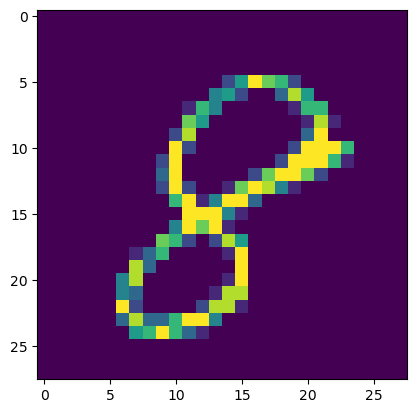

In [13]:
g = plt.imshow(X_train[0][:,:,0])

## Create a model

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## Optimizer

In [15]:
optimizer=RMSprop(lr=0.001)

/Users/monkey/miniconda3/envs/kaggle-solutions/lib/python3.11/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

## Annealer

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Epochs 

In [18]:
epochs = 5
batch_size = 86

## Augment data

In [19]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

## Train the model

In [20]:
datagen.fit(X_train)

In [21]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs = epochs, 
    validation_data = (X_val,y_val),
    verbose = 2, 
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

2024-02-18 04:22:14.422434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-18 04:22:14.428898: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5
439/439 - 32s - loss: 0.4189 - accuracy: 0.8659 - val_loss: 0.0603 - val_accuracy: 0.9817 - lr: 0.0010 - 32s/epoch - 73ms/step
Epoch 2/5
439/439 - 30s - loss: 0.1264 - accuracy: 0.9621 - val_loss: 0.0355 - val_accuracy: 0.9900 - lr: 0.0010 - 30s/epoch - 68ms/step
Epoch 3/5
439/439 - 30s - loss: 0.1002 - accuracy: 0.9705 - val_loss: 0.0324 - val_accuracy: 0.9890 - lr: 0.0010 - 30s/epoch - 69ms/step
Epoch 4/5
439/439 - 31s - loss: 0.0779 - accuracy: 0.9780 - val_loss: 0.0843 - val_accuracy: 0.9743 - lr: 0.0010 - 31s/epoch - 71ms/step
Epoch 5/5
439/439 - 32s - loss: 0.0738 - accuracy: 0.9787 - val_loss: 0.0259 - val_accuracy: 0.9921 - lr: 0.0010 - 32s/epoch - 73ms/step


## Evaluate the model

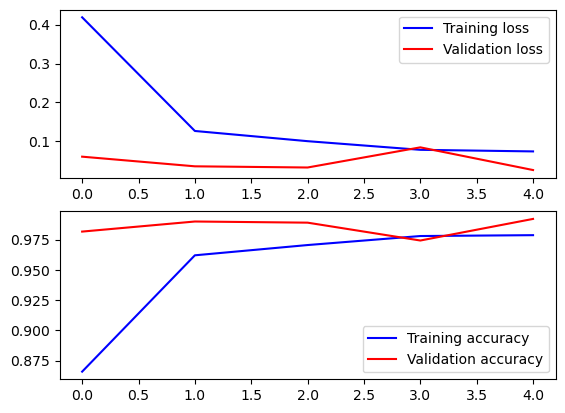

In [22]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best')

plt.show()

In [23]:
history.history['loss']

[0.41889774799346924,
 0.12643732130527496,
 0.10017378628253937,
 0.07792840898036957,
 0.0738404169678688]

## Predict the result 

In [24]:
results = model.predict(test)

875/875 [==============================] - 9s 11ms/step


In [25]:
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [26]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), results], axis = 1)

submission.to_csv("./result/cnn_mnist_datagen.csv",index=False)